# Two-point boundary-value problem

Let's look at methods for the **linear TPBVP**

$$
u''(x) + p(x)u'(x) + q(x)u(x) &= f(x), \quad a < x < b, \\ 
G_{11}u(a) + G_{12}u'(a)  &= \alpha, \\ 
G_{21}u(b) + G_{22}u'(b)  &= \beta. 
$$

For now, we will consider only **Dirichlet conditions** in which $G_{11}=G_{21}=1$, $G_{12}=G_{22}=0$.

We begin with evenly spaced nodes on the domain:

$$
x_i = a + ih, \quad h = \frac{b-a}{n}, \quad i=0,\ldots,n.
$$

There is a close correspondence between a function $u(x)$ and the vector $\bfu$ of its values at the nodes. In order to clarify when we are dealing with the exact solution of the BVP, we denote it by $\hat{u}(x)$ from now on, and its discretization is $\hat{\bfu}$.

<!-- 
We will replace $u''$ and $u'$ at the nodes by FD counterparts. If we aim for 2nd-order accuracy, then we can use centered differences at the interior nodes:

$$
u''(x_i) \approx \frac{u_{i-1}-2u_i+u_{i+1}}{h^2}, \quad u'(x_i) \approx \frac{-u_{i-1}+u_{i+1}}{2h}, \quad i=1,\dots,n-1. 
$$

At the first and last nodes, these formulas refer to fictitious values outside the domain. We could use second-order forward and backward-difference formulas, but it will turn out that the first-order formulas will be fine. So we define the **differentiation matrices** 

$$
\bfD_{xx} = \frac{1}{h^2}  \begin{bmatrix} 
1 & -2 & 1 & & & \\ 
1 & -2 & 1 & & & \\ 
0 & 1 & -2 & 1 & & \\ 
& & \ddots & \ddots & \ddots & \\ 
& & & 1 & -2 & 1 \\
& & & 1 & -2 & 1 
\end{bmatrix}, 
\qquad 
\bfD_{x} = \frac{1}{2h}  \begin{bmatrix} 
-2 & 2 & & & & \\ 
-1 & 0 & 1 & & & \\ 
0 & -1 & 0 & 1 & & \\ 
& & \ddots & \ddots & \ddots & \\ 
& & & -1 & 0 & 1 \\
& & & & -2 & 2 
\end{bmatrix}.
$$ -->

We can discretize $u''$ and $u'$ by using differentiation matrices. The discrete form of the ODE, sans boundary conditions, becomes

$$
\bfA \bfu = \bff, \qquad \bfA = \bfD_{xx} + \bfP \bfD_{x} + \mathbf{Q},
$$

where $\bfP$ and $\mathbf{Q}$ are diagonal matrices of the evaluations of the coefficient functions $p$ and $q$. 

The boundary conditions imply that

$$
u_0 = \alpha, \, u_n = \beta. 
$$

<!-- Recall that matrix-vector multiplication is identical to a linear combination of the matrix columns:

$$
\bfA \bfu = u_0 \bfa_0 + u_1 \bfa_1 + \cdots + u_n \bfa_n. 
$$

Hence the linear system is 

$$
\alpha \bfa_0 + u_1 \bfa_1 + \cdots + \beta \bfa_n & = \bff \\ 
u_1 \bfa_1 + \cdots + u_{n-1} \bfa_{n-1} & = \bff - \alpha \bfa_0  - \beta \bfa_n,
$$

where the right-hand side is a known vector. The left-hand side has $n+1$ rows but only $n-1$ unknowns. Let $\bfC$ be the $(n+1)\times(n+1)$ identity with first and last rows deleted. We arrive at the square linear system

$$
\bfC \bfA \begin{bmatrix} u_1 \\ u_2 \\ \vdots \\ u_{n-1} \end{bmatrix} 
= \begin{bmatrix} f(x_1) - \alpha (1/h^2 + p(x_1)/2h + q(x_1)) \\ f(x_2) \\ \vdots \\ f(x_{n-1}) - \beta (1/h^2 + p(x_{n-1})/2h + q(x_{n-1}))  \end{bmatrix}. 
$$ -->

The easy way to impose these linear conditions is to delete the first and rows of the system and replace them with the boundary conditions: 

$$
\begin{bmatrix} h^{-2} & 0 & \dots & 0 \\ \bfC^T \bfA  \\ 0 & \cdots & 0 & h^{-2} \end{bmatrix} 
\begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_{n-1} \\ u_{n} \end{bmatrix} 
= \begin{bmatrix} \alpha/h^2 \\ f(x_1) \\ \vdots \\ f(x_{n-1}) & \beta/h^2 \end{bmatrix},
$$ 

where $\bfC$ is the $(n+1)\times(n+1)$ identity with first and last columns deleted. Notice that the boundary conditions were scaled by $h^{-2}$ so that all the rows of the linear system have roughly the same magnitude, which improves the condition number of the linear system:

In [1]:
include("diffmats.jl")
n = 300
x,Dx,Dxx = diffmats(0,1,n)
A = Dxx + I
A[[1,n+1],:] .= 0

A[1,1] = 1; A[n+1,n+1] = 1;
println("cond = $(cond(A))")

A[1,1] = n^2; A[n+1,n+1] = n^2;
println("cond = $(cond(A))")

cond = 4.827603951489492e6
cond = 40587.27524232815


We're now going to rechristen the terms in this equation as $\bfA \bfu = \bff$ for simplicity.

## Advection-diffusion

The linear **advection-diffusion equation** in 1D is

$$
\partial_t u + c \partial_x u = k \partial_{xx} u, \quad c, k \ge 0. 
$$

When $k=0$, everything is simply transported with velocity $c$, and when $c=0$, the equation represents pure diffusion. The balance between the terms can be expressed by the **Peclet number**

$$
\text{Pe} = \frac{c}{k}. 
$$

Using $\lambda=\text{Pe}^{-1}$, we will solve the steady-state problem

$$
\partial_x u = \lambda \partial_{xx} u
$$

subject to $u(-1)=1$, $u(1)=-1$.

In [2]:
function advdiff(a,b,λ,n)
    x,Dx,Dxx = diffmats(a,b,n)
    A = Dx - λ*Dxx
    A[[1,n+1],:] .= 0
    A[1,1] = A[n+1,n+1] = n^2
    f = [n^2; zeros(n-1); -n^2]
    return x,A\f 
end

advdiff (generic function with 1 method)

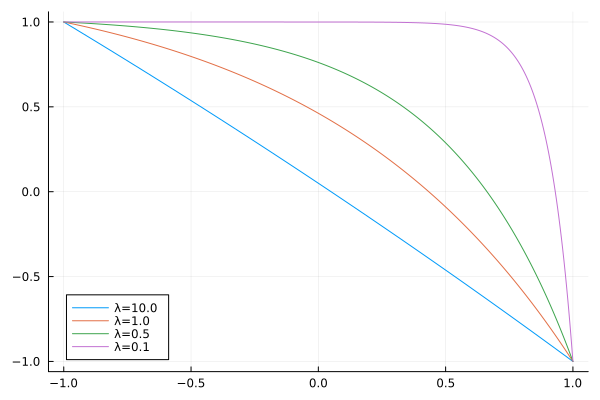

In [3]:
using Plots
plt = plot(legend=:bottomleft)
for λ in [10,1,0.5,0.1]
    x,u = advdiff(-1,1,λ,400)
    plot!(x,u,label="λ=$λ")
end
plt

## Convergence

Measuring convergence in the absence of an exact analytical solution (as is the usual case) can require some finesse. It's standard to obtain a high-accuracy numerical solution by running the method on a large grid, or by using an alternative method. But the FD method produces function point values, not functions, so they are not instantly comparable when solved on different node sets. 

One option is to define a function by interpolating the data values. This may be possible with reasonable accuracy in one dimension, but is much harder in higher dimensions. Below we use an alternative, which is to solve repeatedly on nested or *dyadic* grids. The solutions can then be compared directly on a set of nodes that they have in common. You can use the infinity-norm or the 2-norm. In the case of the vector 2-norm, you should scale by $\sqrt{h}$ or by the exact solution to avoid penalizing larger discretizations for no reason.

In [4]:
λ = 1
n = [10*2^m for m in 1:8]
sol = []
for n in n
    x,u = advdiff(-1,1,λ,n)
    push!(sol,u)
end

û = sol[end]
err = []
for (i,u) in pairs(sol)
    push!(err,norm(û[1:2^(8-i):end]-u)/norm(u))
end

using PrettyTables
pretty_table((n=n,error=err,ratio=[NaN;err[1:end-1]./err[2:end]]))

┌───────┬─────────────┬─────────┐
│     n │       error │   ratio │
│ Int64 │         Any │ Float64 │
├───────┼─────────────┼─────────┤
│    20 │ 0.000377216 │     NaN │
│    40 │  9.70311e-5 │ 3.88758 │
│    80 │  2.46009e-5 │ 3.94421 │
│   160 │  6.17833e-6 │  3.9818 │
│   320 │  1.53218e-6 │ 4.03237 │
│   640 │  3.65498e-7 │ 4.19205 │
│  1280 │  7.31691e-8 │ 4.99524 │
│  2560 │         0.0 │     Inf │
└───────┴─────────────┴─────────┘


The above table indicates roughly 2nd-order accuracy.


## Consistency and stability

::::{prf:definition} Truncation error for a BVP
The **local truncation error** for the discretized TPBVP $\bfA\bfu = \bff$ is the vector

$$
\mathbf{t} = \bfA \hat{\bfu} - \bff,
$$

where $\hat{\bfu}$ is the exact solution of the TPBVP evaluated on the nodes. The method is **consistent** if $\| \mathbf{t} \| \to 0$ as $h\to 0$. 
::::

Consistency means a faithful reproduction of the problem. The truncation error is determined directly by our choice of FD formulas. On the other hand, what we really want to understand or control is the actual (or global) error, $\bfe = \hat{\bfu} - \bfu$. Observe that

$$
\mathbf{t} = \bfA (\bfe + \bfu) - \bff = \bfA \bfe + (\bfA\bfu-\bff) =  \bfA \bfe. 
$$

That is, the global error is the solution of the linear system $\bfA\bfe = \mathbf{t}$. We now know another property our method needs.

::::{prf:definition}
  The FD method producing $\bfA \bfu = \bff$ for the TPBVP is **stable** if $\| \bfA ^{-1} \|$ is bounded above as $h\to 0$.
::::

We have pretty much defined our way to the climax.

::::{prf:theorem}
  An FD method is convergent if it is consistent and stable. Moreover, the global error converges at the same order as the truncation error.
::::

Consider what a lack of stability would imply. If we perturb $\bff$ by *any* small vector $\bfv$, then the solution is perturbed by $\bfA^{-1} \bfv$, which could grow unboundedly as $h\to 0$. Truncation error is one such perturbation, but so are roundoff and physical measurement error. Without stability, the computed solution is unboundedly sensitive to such errors.

It is possible to prove stability of our discretization with some conditions on the coefficient functions $p$ and $q$. 


::::{prf:example} 
LeVeque points out that in the particular case $p=q=0$ on the domain $x\in[-1,1]$, the matrix $\bfA = \bfC^T\bfD_{xx}\bfC$ is symmetric and its eigenvalues can be found in closed form:

$$
\lambda_k = \frac{2}{h^2} \left[ \cos\left(\frac{k\pi h}{2}\right)-1 \right], \quad k=1,\ldots,n-1. 
$$

Observe that 

$$
\frac{k\pi h}{2} = \frac{k\pi}{n} \in (0,\pi),
$$

so that the eigenvalues decrease monotonically with $k$. Moreover,

$$
\cos\left(\frac{(n-1)\pi}{n}\right) = \cos\left(\pi - \frac{\pi}{n}\right) = -1 + O(n^{-2}) = -1 + O(h^2),
$$

and

$$
\cos\left(\frac{\pi}{n}\right) = 1 - \frac{\pi^2}{2n^2} + O(n^{-4}) = 1 - \frac{\pi^2 h^2}{8} + O(h^{4}). 
$$

Thus, the eigenvalues are negative, real, and lie between

$$
\frac{-4}{h^2} + O(1)
$$

and

$$ 
\frac{\pi^2}{4} + O(h^2). 
$$

Since the matrix is normal, the singular values are the absolute values of the eigenvalues, and 

$$
\norm{\bfA^{-1}} = \frac{1}{\pi^2/4} = O(1)
$$

as $h\to 0$, thereby proving stability.
::::